In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Image:
    def __init__(self, path):
        self.image = cv2.imread(path, 0)

    def show_image(self):
        cv2.imshow('Before modification', self.image)
        cv2.waitKey(0)
    # to calculate total number of pixels
    def cal_tot(self):
        self.tot_pxls = self.image.shape[0] * self.image.shape[1]

    def intensity_dist(self):
        self.intensity_probabilities = np.zeros(256)
        self.intensity_counts = np.zeros(256, dtype=int)
        for row in self.image:# to iterate over rows of the img
            for pixel in row:#iterate over each pixel in the row
                intensity = pixel
                self.intensity_counts[intensity] += 1#count the occurance of this intensity
        self.intensity_probabilities = self.intensity_counts / self.tot_pxls #make the intensity probabilities 

    def show_intensity_dist(self):
        plt.plot(self.intensity_counts, color='purple')
        plt.title('Intensity Distribution')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        plt.show()
        print('the length of the img ', len(self.intensity_counts))
        print('counting of intensities ', self.intensity_counts)
        print('probability of intensities ', self.intensity_probabilities)


    def nearest_neighbor_interpolation(self, scale_factor):
        scaled_width = int(self.image.shape[1] * scale_factor)
        scaled_height = int(self.image.shape[0] * scale_factor)
        scaled_image = np.zeros((scaled_height, scaled_width), dtype=np.uint8)
        
        for i in range(scaled_height):
            for j in range(scaled_width):
                original_i = int(i / scale_factor)# get the number of row
                original_j = int(j / scale_factor)#get number of column to get the pos from the original img
                scaled_image[i, j] = self.image[original_i, original_j]
        
        return scaled_image
    def bilinear_interpolation(self, scale):
        scaled_height = int(self.image.shape[0] * scale)
        scaled_width = int(self.image.shape[1] * scale)
        scaled_image = np.zeros((scaled_height, scaled_width), dtype=np.uint8)
        #get the 4 cooridinate of the pixels 
        for i in range(scaled_height):
            for j in range(scaled_width):
                src_i = i / scale # divide by the scale vlue to get the pos of pixel to intepolated
                src_j = j / scale
                # the 4 coordinate to the corresponding pixel
                #top-left (i1, j1), top-right (i1, j2), bottom-left (i2, j1), and bottom-right (i2, j2) pixels.
                i1 = int(np.floor(src_i))
                i2 = int(np.ceil(src_i))
                j1 = int(np.floor(src_j))
                j2 = int(np.ceil(src_j))
                #handle the boudary issue
                if i2 >= self.image.shape[0]:
                    i2 = self.image.shape[0] - 1
                if j2 >= self.image.shape[1]:
                    j2 = self.image.shape[1] - 1
                # calculate the distance between source coordinate and top left
                dx = src_i - i1
                dy = src_j - j1

                # Perform bilinear interpolation #l1 top-left with interpolated vlue
                #l2 top-right with interpolated value
                #l3bottom right with interpolated
                #by sum it cal weighted avg
                interpolated_value = (1 - dx) * (1 - dy) * self.image[i1, j1] \
                                     + dx * (1 - dy) * self.image[i2, j1] \
                                     + (1 - dx) * dy * self.image[i1, j2] \
                                     + dx * dy * self.image[i2, j2]

                scaled_image[i, j] = int(interpolated_value)

        return scaled_image
    def bicubic_interpolation(self, scale_factor):
        #16 neigborhod
        height, width = self.image.shape
        #get the dimension of scaled img
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)

        scaled_image = np.zeros((new_height, new_width), dtype=np.uint8)

        for i in range(new_height):
            for j in range(new_width):
                x = (j + 0.5) / scale_factor - 0.5 #to calculate it diagonaly 
                y = (i + 0.5) / scale_factor - 0.5

                x1 = int(np.floor(x))#get the real diagonal this are top left
                y1 = int(np.floor(y))

                dx = x - x1 #cal dx and dy as bilinear  to get the position
                dy = y - y1

                interpolated_value = 0
                #make bicubic with center x1 y1
                for m in range(-1, 3):
                    for n in range(-1, 3):
                        #to check neigbor coordinate are within the image itself 
                        if (x1 + m >= 0 and x1 + m < width and y1 + n >= 0 and y1 + n < height):
                            weight_x = self.bicubic_weight(dx - m)
                            weight_y = self.bicubic_weight(dy - n)
                            interpolated_value += weight_x * weight_y * self.image[y1 + n, x1 + m]

                scaled_image[i, j] = interpolated_value.astype(np.uint8)

        return scaled_image
    #usd to get contibution for every pixel in 4x4 negibor from x
    def bicubic_weight(self, x):
        x = np.abs(x)
        if x <= 1:
            return 1 - 2 * x**2 + x**3 
        #It starts with a weight of 1,
        #then subtracts twice the square term to reduce the contribution of nearby pixels,
        # and finally adds the cube term to amplify the contribution of pixels very close to the target
        elif x < 2:
            return 4 - 8 * x + 5 * x**2 - x**3
        # It starts with a weight of 4, then subtracts eight times x to reduce the contribution of nearby pixels, 
        # adds five times x**2 to increase the contribution of pixels within the desired range,
        # and finally subtracts x**3 to decrease the contribution of pixels very close to the target.
        else:
            return 0

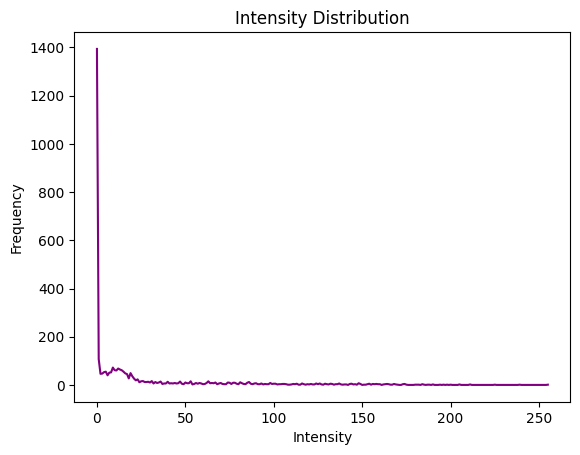

the length of the img  256
counting of intensities  [1394  107   46   47   53   55   40   51   52   72   61   60   68   64
   61   55   48   45   27   49   36   26   19   23   11   15   16   12
   12   13   10   16    6   12    8   10   14    4    6    6   13    6
    7    6    8    6    7   14    5    3   10    7    7   15    2    4
    8    5    8    6    3    4    8   15    7    8    7   10    3    6
    8    4    3    3   10    9    4    9    9    5    3   11    7    4
    3    9   12    5    3    6    7    3    3    6    2    4    3    3
    8    4    5    5    2    3    3    4    4    3    1    1    2    4
    3    5    1    1    6    3    1    3    2    4    2    2    6    3
    6    2    1    5    3    2    5    4    1    3    3    6    2    1
    2    2    0    4    5    2    3    1    7    4    0    1    1    3
    5    1    4    3    4    3    3    0    2    3    4    3    1    1
    4    2    1    0    0    3    4    1    0    0    0    0    1    1
    1    0    3    1    0

-1

In [3]:
img=Image("07.jpg")
img.show_image()
img.cal_tot()
img.intensity_dist()
img.show_intensity_dist()
# scaled_image = img.nearest_neighbor_interpolation(2.0)
# scaled_image = img.bilinear_interpolation(2.0)
scaled_image = img.bicubic_interpolation(2.0)
cv2.imshow('Scaled Image', scaled_image)
cv2.waitKey(0)
